In [1]:
import sys, pathlib
module_path = pathlib.Path("__file__").resolve().parent
sys.path.insert(0, str(module_path))

### Load the data

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from mof_galaxy.main import get_data


# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_graph, val_graph, test_graph = get_data(device, 
                                              num_val=0.2, 
                                              num_test=0.0, 
                                              alpha=0.9, 
                                              omega=0.9)

### Optimized Models

#### 1) MLP (BaseLine)

In [3]:
class MLP(nn.Module):
    def __init__(self, 
                 num_features, 
                 num_classes, 
                 num_hidden_layers, 
                 hidden_layer_neurons, 
                 dropout_prob,
                 use_edge_weights=False
                ):
        
        super().__init__()
        self.use_edge_weights = use_edge_weights

        # Input layer
        layers = [nn.Linear(num_features, 
                            hidden_layer_neurons[0]), 
                  nn.ReLU(), 
                  nn.Dropout(p=dropout_prob)]

        # Hidden layers
        for i in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_layer_neurons[i], 
                                     hidden_layer_neurons[i + 1]), 
                           nn.ReLU(), 
                           nn.Dropout(p=dropout_prob)])

        # Output layer
        layers.append(nn.Linear(hidden_layer_neurons[-1], 
                                num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        if self.use_edge_weights and hasattr(data, 'edge_weight'):
            edge_weight = data.edge_weight.view(-1, 1)
            x = x * edge_weight

        output = self.layers(x)
        return output

mlp = MLP(num_features=train_graph.x.shape[1], 
          num_classes=len(train_graph.y.unique()),
          dropout_prob=2.499e-03,
          num_hidden_layers=3,
          hidden_layer_neurons=[32, 64, 64]
         ).to(device)


#### 2) GCN

In [4]:
class GCN(nn.Module):
    def __init__(self, 
                 num_features, 
                 num_classes, 
                 num_hidden_layers, 
                 hidden_layer_neurons, 
                 dropout_prob, 
                ):
        
        super(GCN, self).__init__()

        # Input layer
        self.conv1 = GCNConv(num_features, hidden_layer_neurons[0])

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden_layers - 1):
            self.hidden_layers.append(GCNConv(hidden_layer_neurons[i], 
                                              hidden_layer_neurons[i + 1]))

        # Output layer
        self.fc = nn.Linear(hidden_layer_neurons[-1], 
                            num_classes)
        
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Input layer
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)

        # Hidden layers
        for layer in self.hidden_layers:
            x = F.relu(layer(x, edge_index))
            x = self.dropout(x)

        # Output layer
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

gcn = GCN(num_features=train_graph.x.shape[1], 
          num_classes=len(train_graph.y.unique()),
          dropout_prob=2.848e-03,
          num_hidden_layers=3,
          hidden_layer_neurons=[32, 64, 16]
         ).to(device)


#### 3) GraphSAGE 

In [5]:
class GraphSAGE(nn.Module):
    def __init__(self, 
                 num_features, 
                 num_classes, 
                 dropout_prob, 
                 num_hidden_layers, 
                 hidden_layer_neurons
                ):
        
        super(GraphSAGE, self).__init__()

        # Input layer
        self.conv1 = SAGEConv(num_features, hidden_layer_neurons[0])

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden_layers - 1):
            self.hidden_layers.append(SAGEConv(hidden_layer_neurons[i], 
                                               hidden_layer_neurons[i + 1]))

        # Output layer
        self.fc = nn.Linear(hidden_layer_neurons[-1], num_classes)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Input layer
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)

        # Hidden layers
        for layer in self.hidden_layers:
            x = F.relu(layer(x, edge_index))
            x = self.dropout(x)

        # Output layer
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

graphsage = GraphSAGE(num_features=train_graph.x.shape[1], 
                      num_classes=len(train_graph.y.unique()),
                      dropout_prob=1.349e-03,
                      num_hidden_layers=3,
                      hidden_layer_neurons=[32, 64, 64]
                     ).to(device)

##### Training

- batch_size : 202
- lr : 1.499e-02
- lr_step : 500
- lr_gamma : 9.029e-01
- epochs : 10000

In [6]:
%%time

from mof_galaxy.main import train, plot_results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("poster")

train_params = {"train_graph" : train_graph, 
                "val_graph" : val_graph, 
                "num_epochs" : 10000,
                "batch_size" : 202, 
                "lr" : 1.499e-02, 
                "lr_step" : 500, 
                "lr_gamma" : 9.029e-01, 
                "display_freq" : 2000}

print("\nMLP Training\n")
mlp, mlp_stats = train(mlp, **train_params)

print("\nGCN Training\n")
gcn, gcn_stats = train(gcn, **train_params)

print("\nGraphSAGE Training\n")
graphsage, graphsage_stats = train(graphsage, **train_params)


MLP Training

Epoch 2000/10000 (learning rate: 9.962e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.809, 0.780] 	 Accuracy [Train, Val]: [0.661, 0.663]

Epoch 3999/10000 (learning rate: 7.333e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.775, 0.746] 	 Accuracy [Train, Val]: [0.670, 0.681]

Epoch 5998/10000 (learning rate: 4.873e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.752, 0.730] 	 Accuracy [Train, Val]: [0.675, 0.683]

Epoch 7997/10000 (learning rate: 3.239e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.736, 0.725] 	 Accuracy [Train, Val]: [0.679, 0.686]

Epoch 9996/10000 (learning rate: 2.153e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.746, 0.719] 	 Accuracy [Train, Val]: [0.682, 0.688]


GCN Training

Epoch 2000/10000 (learning rate: 9.962e-03)
------------------------------------

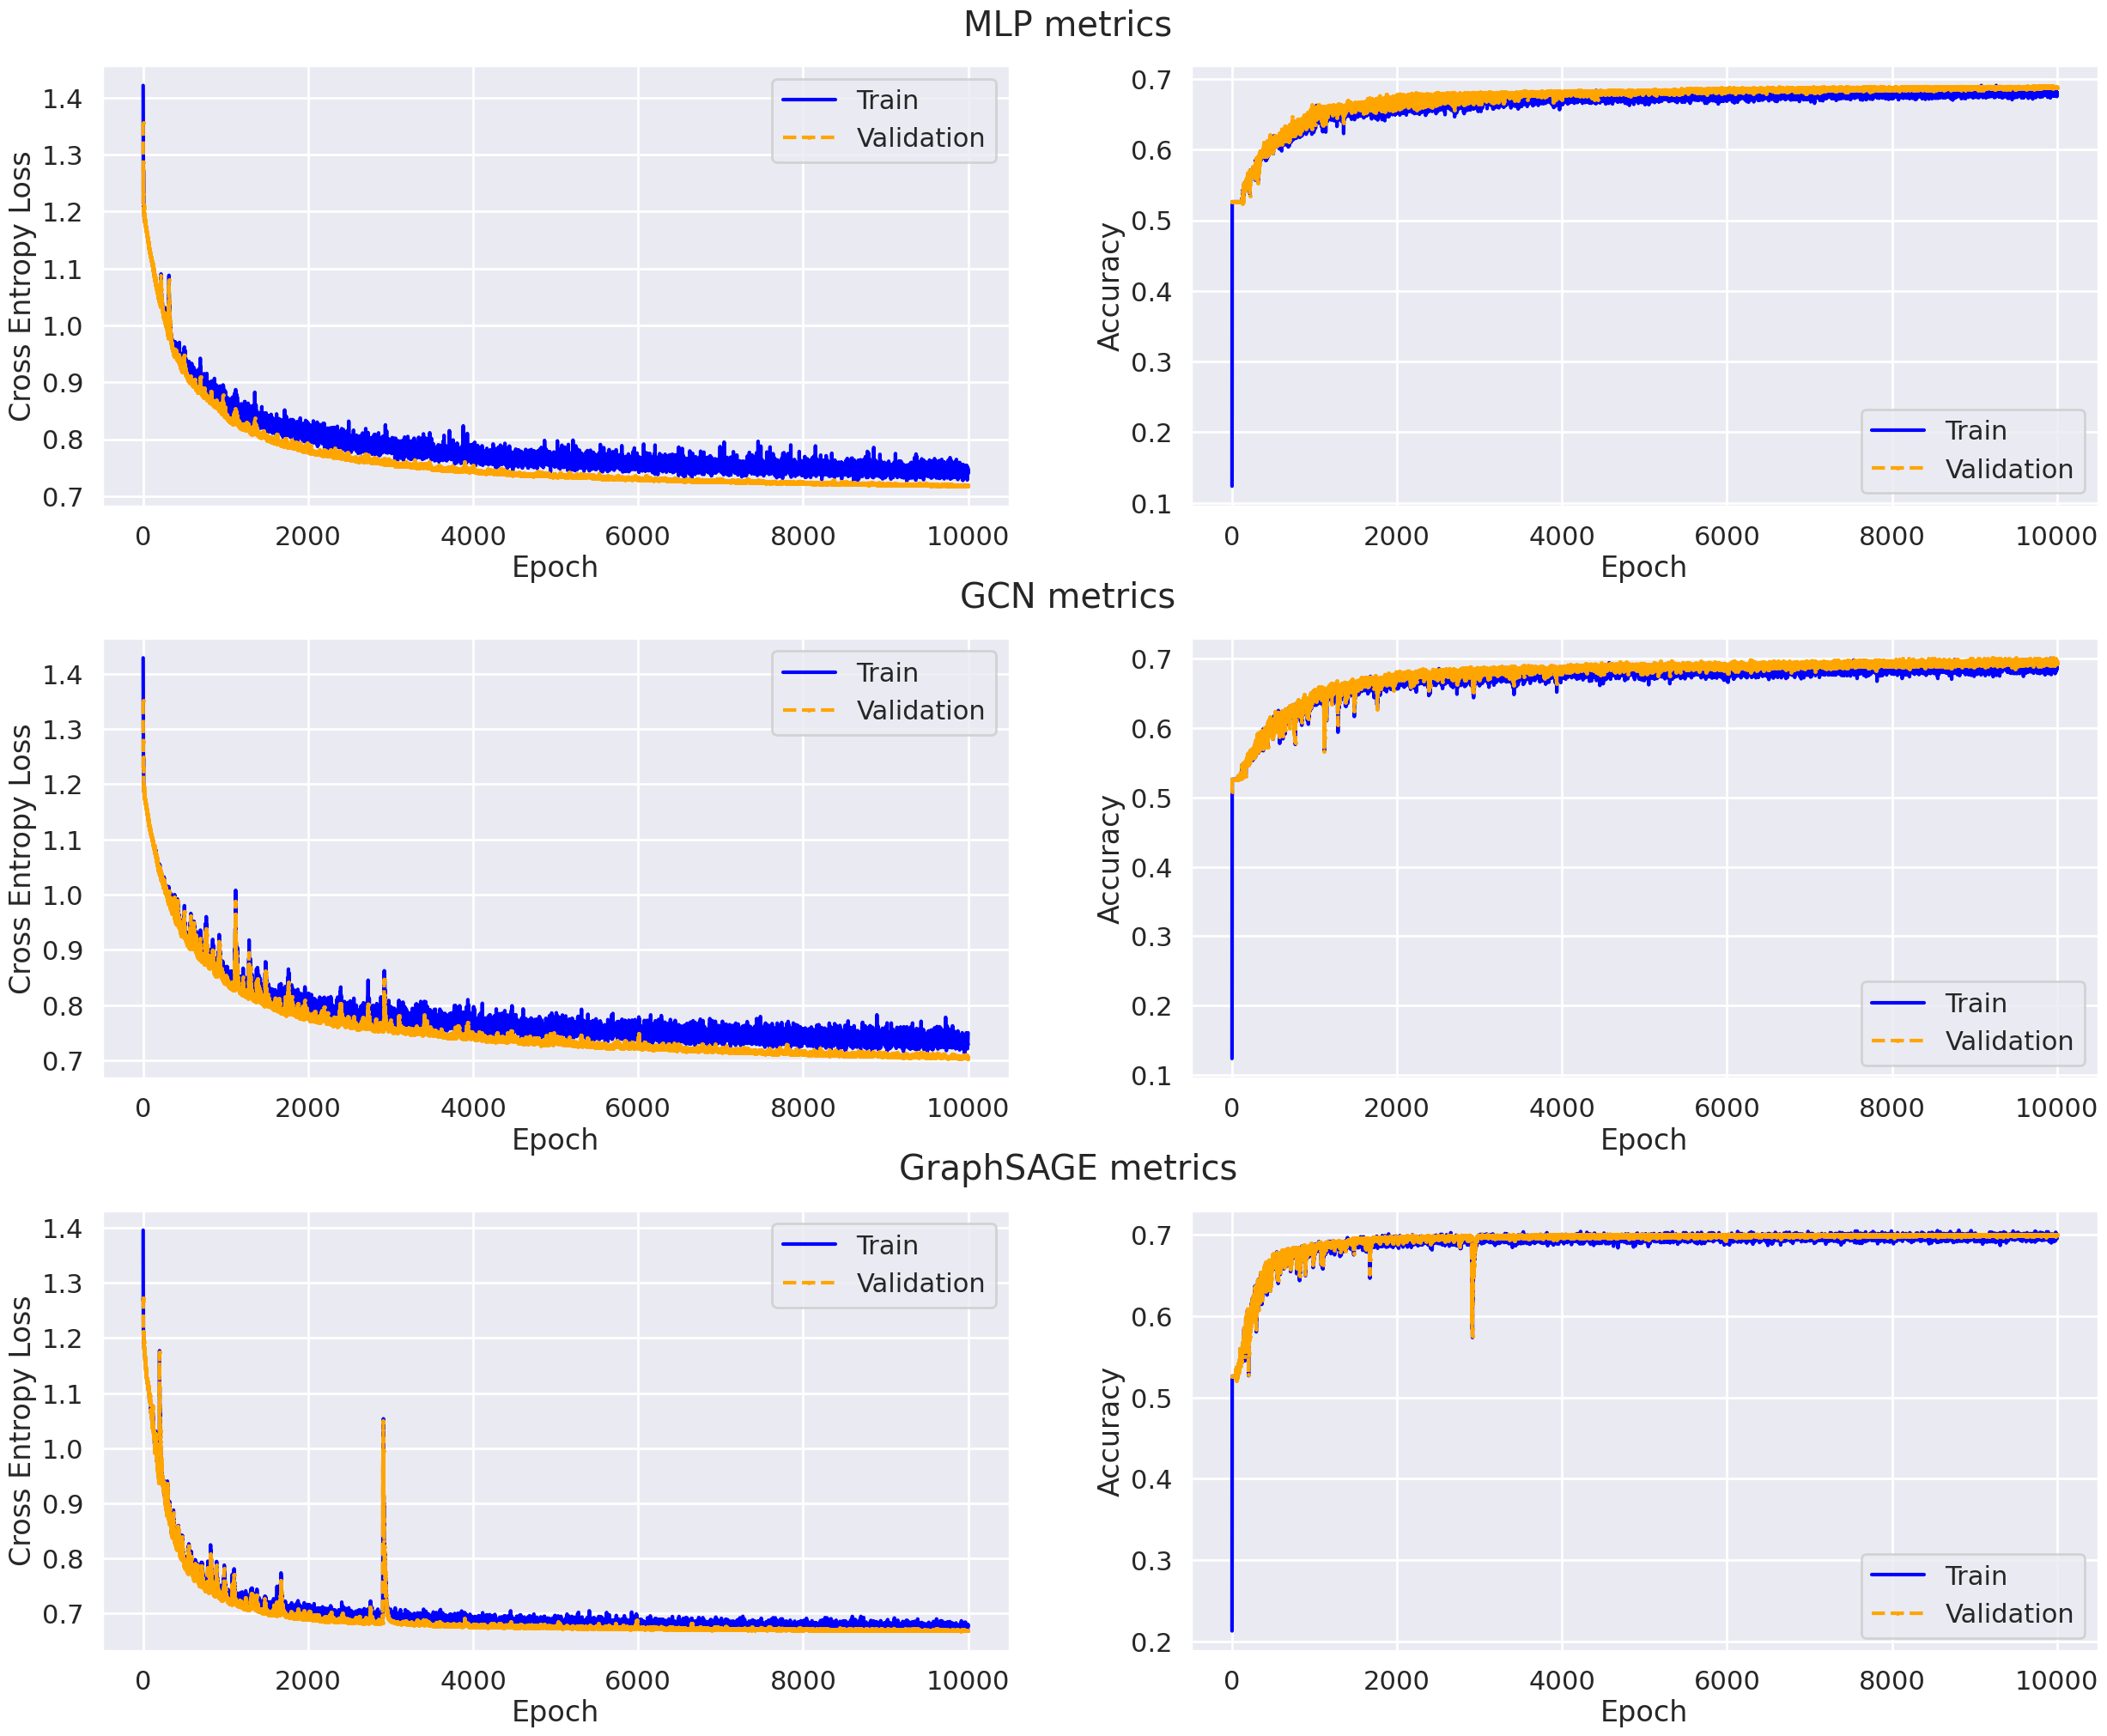

In [7]:
from mof_galaxy.main import train, plot_results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("poster")

fig = plt.figure(figsize=(30, 20))
fig.tight_layout()

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):   
    if row == 0: 
        subfig.suptitle(f"MLP metrics")
        model_stats = mlp_stats
    elif row == 1:
        subfig.suptitle(f"GCN metrics")
        model_stats = gcn_stats
    else:
        subfig.suptitle(f"GraphSAGE metrics")
        model_stats = graphsage_stats
    # create 1x2 subplots per subfig
    ax1, ax2 = subfig.subplots(nrows=1, ncols=2)
    ax1, ax2 = plot_results(ax_loss=ax1, ax_acc=ax2, model_stats=model_stats)

### t-SNE visualization of Node embeddings 

In [8]:
from sklearn.manifold import TSNE
import numpy as np

def get_node_embeddings(model, data):
    if model:
        with torch.no_grad():
            node_embeddings = model(train_graph).cpu().numpy()
    else:
        node_embeddings = np.concatenate((data.x.cpu().numpy(), 
                                   data.y.cpu().numpy().reshape(-1, 1)
                                  ),
                                  axis=1
                                 )
    tsne = TSNE(n_components=2, random_state=271)
    tsne_embeddings = tsne.fit_transform(node_embeddings)
    classes = train_graph.y.cpu().numpy()
    tsne_node_embeddings = {}
    for cls in np.unique(classes):
        indices = np.argwhere(classes == cls)
        tsne_node_embeddings.update({cls : tsne_embeddings[indices].reshape(-1, 2)})
    return tsne_node_embeddings

def plot_embeddings(tsne_node_embeddings, ax):
    for cls, tsne_embeddings in tsne_node_embeddings.items():
        if cls == 0:
            ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], 
                       label="Non-porous (class 0)", color="blue", s=5)
        elif cls == 1:
            ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], 
                       label="Small (class 1)", color="green", s=5)
        elif cls == 2:
            ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], 
                       label="Medium (class 2)", color="red", s=5)
        elif cls == 3:
            ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], 
                       label="Large (class 3)", color="yellow", s=5)
    return ax

data_tsne = get_node_embeddings(None, train_graph)
mlp_tsne = get_node_embeddings(mlp, train_graph)
gcn_tsne = get_node_embeddings(gcn, train_graph)
graphsage_tsne = get_node_embeddings(graphsage, train_graph)

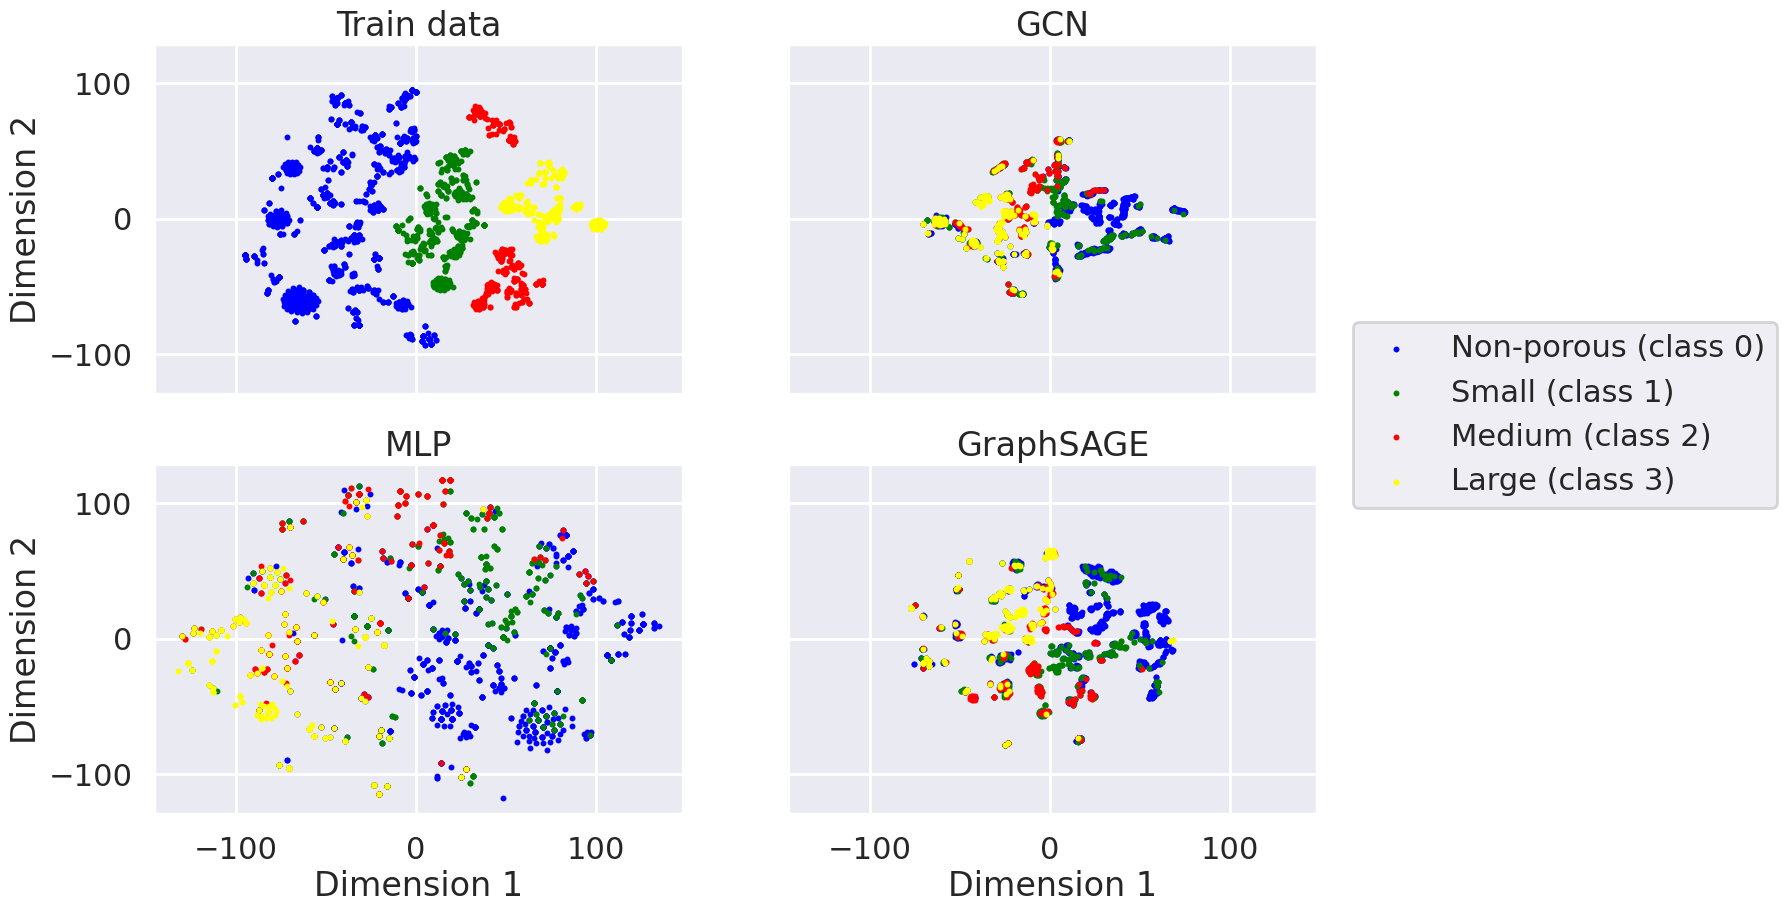

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15, 10))

axes[0, 0] = plot_embeddings(data_tsne, axes[0, 0])
axes[0, 0].set_ylabel("Dimension 2")
axes[0, 0].set_title("Train data")

axes[1, 0] = plot_embeddings(mlp_tsne, axes[1, 0])
axes[1, 0].set_title("MLP")
axes[1, 0].set_ylabel("Dimension 2")
axes[1, 0].set_xlabel("Dimension 1")

axes[0, 1] = plot_embeddings(gcn_tsne, axes[0, 1])
axes[0, 1].set_title("GCN")

axes[1, 1] = plot_embeddings(graphsage_tsne, axes[1, 1])
axes[1, 1].legend(bbox_to_anchor=[1.9, 1.45])
axes[1, 1].set_title("GraphSAGE")
axes[1, 1].set_xlabel("Dimension 1")

plt.show()

### Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix
from torch_geometric.loader import DataLoader

# Function to generate confusion matrix
def generate_confusion_matrix(model, val_graph):
    model.eval()
    val_loader = DataLoader([val_graph], batch_size=202, shuffle=False)

    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in val_loader:
            output = model(batch)
            predictions = output.argmax(dim=1).cpu().numpy()
            true_labels = batch.y.cpu().numpy()

            all_predictions.extend(predictions)
            all_true_labels.extend(true_labels)

    # Create confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    return cm

# Generate confusion matrix for models
mlp_confusion_matrix = generate_confusion_matrix(mlp, val_graph)
gcn_confusion_matrix = generate_confusion_matrix(gcn, val_graph)
graphsage_confusion_matrix = generate_confusion_matrix(graphsage, val_graph)

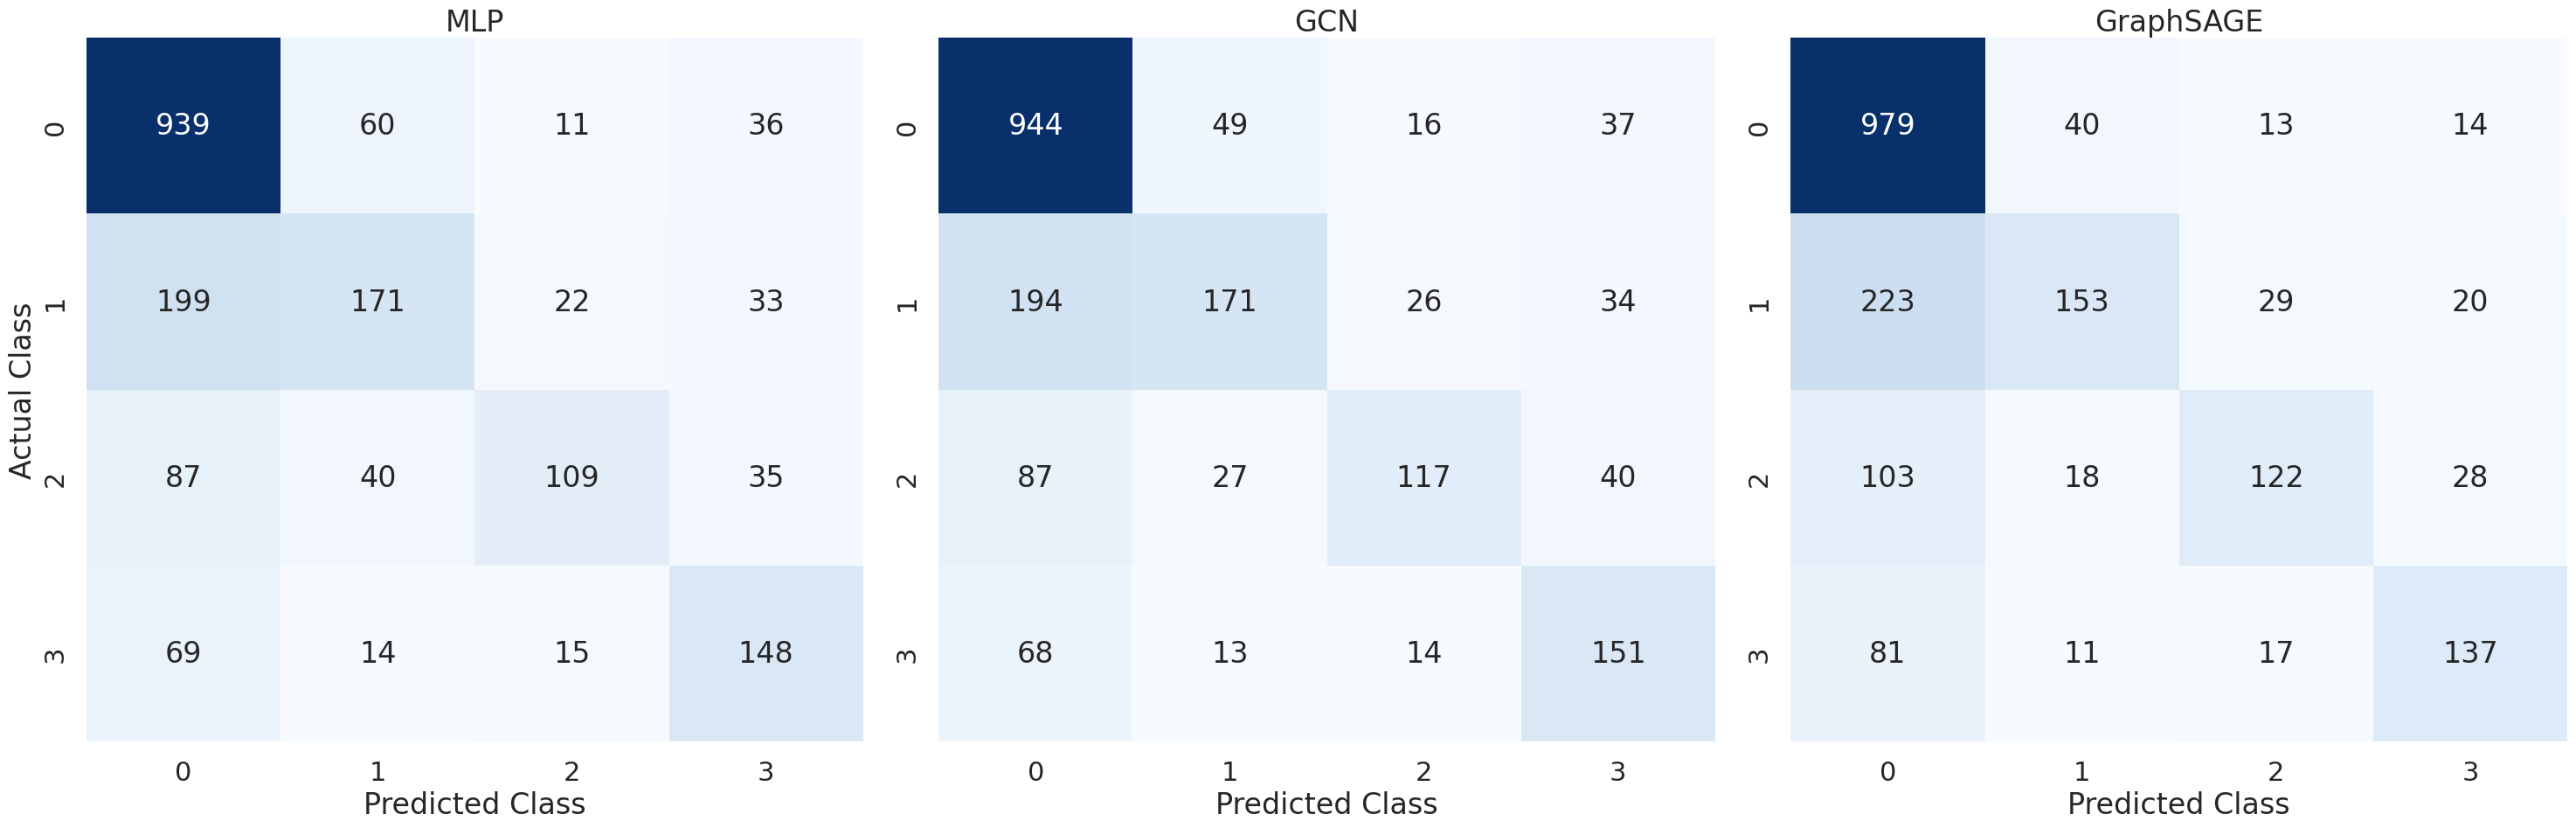

In [26]:
def plot_confusion_matrix(confusion_matrix, ax):
    ax = sns.heatmap(confusion_matrix, 
                     annot=True,
                     fmt = "d",
                     cmap="Blues", 
                     xticklabels=[0, 1, 2, 3], 
                     yticklabels=[0, 1, 2, 3],
                     cbar=False,
                     ax=ax
                    )
    return ax

# Plot the confusion matrix
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

axes[0] = plot_confusion_matrix(mlp_confusion_matrix, axes[0])
axes[0].set_ylabel("Actual Class")
axes[0].set_xlabel("Predicted Class")
axes[0].set_title("MLP")

axes[1] = plot_confusion_matrix(gcn_confusion_matrix, axes[1])
axes[1].set_xlabel("Predicted Class")
axes[1].set_title("GCN")

axes[2] = plot_confusion_matrix(graphsage_confusion_matrix, axes[2])
axes[2].set_xlabel("Predicted Class")
axes[2].set_title("GraphSAGE")

plt.tight_layout()
plt.show()